In [1]:
#CNN is .better than multilayer perceptions and has less parameters than dense layers.Convolution, pooling are main parts.
#CONVOLUTION:#Kernel is also called filter.Kernel is matrix of weight elements.Greyscale Image is converted into pixels matrix.
#Output is of same dimension as input original image.WE consider dot product of image and kernel.
#Apply zero padding to the edge multiplications.


In [2]:
#Kernel is a feature detector filter.Eg oblique line or vertical line detector.Model self learns the kernel.
#By learning the weights of kernel we train CNN.Grid size is same as order of matrix.We specify grids with odd numbers.
#In odd kernels we have center pixel as a reference value.Step size to slide kernel on image is called stride..
#Same stride for horizonal as well as vertical is mostly used.
#For color image RGB are 3 different kernel matrices.Eg 3x3x3 means order 3x3 with third parameter as depth.
#Depth is same as channels as RGB are three channels of light or color.So for image we have 3d array

In [3]:
#POOLING:It downsamples the images and shrinks the image.In DL max pooling is frequently used.just a mathematical operation.
#We pass input data to convolution layers + relu and then to pool layers and repeat this again for feauture learning .
#then we flatten the i/p and see fully connnected networks to get output using softmax activation fxn.
#mmoving from one layr to another we get high level features.

In [4]:
#CNN in AUDIO:CNN can be applied.Take spectrograms or MFCCS as images.Amplitude can act as pixel value.
#Time and frequency are the x and y axis of image.Audio data has correlated structures like image and we can implement CNN.
#Data shape=51200/512x13x1 where 51200 is no of samples in udio & 512 is Hoplength.13 are the mfccs of audio.
# 1 is the depth and audio data is like monochannel or just greyscale.

In [5]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import librosa

DATA_PATH = "MFCC_Data.json"


In [6]:
def load_data(data_path):
#     Loads training dataset from json file.
    
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y



In [7]:
def plot_history(history):
    #Plots accuracy/loss for training/validation set as a function of the epochs
    

    fig, axs = plt.subplots(2)

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

In [8]:
def prepare_datasets(test_size, validation_size):
    #Loads data and splits it into train, validation and test sets.
    

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    #we split our data into train test and train validation..
    #For CNN tensor flow accepts a 3D array...X train is 2D here.We tear channel as 1 like a greyscle image (monochannel)
    #(X,Y,1)
    X_train = X_train[..., np.newaxis]#4D array with ist value as [samples , X,Y,1]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [9]:
def build_model(input_shape):#Model of CNN with 3 convolutional layers and later max pooling...
    #param input_shape..

    #making network Architechture,..
    model = keras.Sequential()

    # 1st conv layer,Adding a layer to the model usind .add()
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    #We use pooling to down sample our input..Matrix is 3x3 and stride of 2 with zero padding at edges.
    model.add(keras.layers.BatchNormalization())
    #We have 32 filters and 3x3 grid size kernel with relu activation fxn.
    #in input_shape we want to use X_train's X,Y,depth terms.Input shape is a tuple here of 3 values for convolution.

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    #Batch normalisation normalises/standardises the activation fxn of current layer.
    #model converges a way faster with more reliability and training is speeded up alot.

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    #using keras and tensor flow we flatten 2D array of layers to 1D array.
    #Adding fully connected dense layer for classification.There are 64 neurons.
    model.add(keras.layers.Dense(64, activation='relu'))#Fed flattened o/p to dense layer..
    model.add(keras.layers.Dropout(0.3))
    #30% dropout to solve overfitting problem...

    # output layer This uses softmax fxn to get probability distribution.
    model.add(keras.layers.Dense(10, activation='softmax')) 
    #Here we have 10 neurons because we have 1-0 genres in dataset to classify ..
    return model

In [10]:
genre_list = ['Blues','Classical','Country','Disco','Hiphop','Jazz','Metal','Pop','Reggae','Rock'] 
def predict(model, X, y):#Passed model in the prediction..
    
    
    # add a dimension to input data for sample - model.predict() expects a 4d array
    X = X[np.newaxis, ...]# (1, 130, 13, 1)We are adding extra dimension to make a 4D array.

    # perform prediction
    prediction = model.predict(X)

    predicted_index = np.argmax(prediction, axis=1)
    #Out of prediction array we want to extract the max probable value.Gives 1D value b/w 0 to 9.
    
    print("Target: {}, Predicted label: {}".format(genre_list[y], genre_list[predicted_index[0]]))
    return predicted_index[0]



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 11, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 6, 32)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 6, 32)        128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 4, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 2, 32)        0         
 2D)                                                             
                                                        

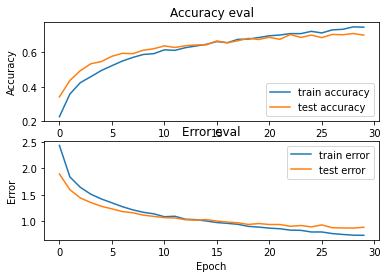

79/79 - 1s - loss: 0.8414 - accuracy: 0.7012 - 587ms/epoch - 7ms/step

Test accuracy: 0.7012414932250977
Target: Metal, Predicted label: Metal


6

In [11]:
#main function

 # get train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)
# create network
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
 # train model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

# plot accuracy/error for training and validation
plot_history(history)

# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

# pick a sample to predict from the test set
X_to_predict = X_test[100]
y_to_predict = y_test[100]

# predict sample
predict(model, X_to_predict, y_to_predict)

In [16]:
model.save('my_model_cnn.h5')

In [17]:
X_to_predict = X_test[102]
y_to_predict = y_test[102]

# predict sample
predict(model, X_to_predict, y_to_predict)

Target: Hiphop, Predicted label: Hiphop


4

In [32]:

file_path = "TestAudios/rock.wav"
signal, sample_rate = librosa.load(file_path, sr=22050)

In [33]:
signal

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [34]:
sample_rate

22050

In [35]:
mfcc = librosa.feature.mfcc(signal, sample_rate, n_mfcc=13, n_fft=2048, hop_length=512)
mfcc = mfcc.T
test  = mfcc
# predict(model, test, y_to_predict)
mfcc.shape

(4473, 13)

In [36]:
model = tf.keras.models.load_model('my_model_cnn.h5')

In [38]:
import math
import tensorflow as tf
import os
def save_mfcc(f,num_mfcc=13,n_fft=2048,hop_length=512,num_segments=10):
    SAMPLE_RATE = 22050
    TRACK_DURATION = 30 #seconds
    SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION#6 lacs approx.. 30*22050
    #dictionary for data storage
    data={
         "mapping":[],#All genres are mapped here
          "mfcc":[],#mfccs for each segment
          "labels":[]#Labels for each segment
        #Mfccs are training inputs and labels are the outputs.
        
        
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

  

    # load audio file
    file_path = f
    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
     # process all segments of audio file
    for d in range(num_segments):

        # calculate start and finish sample for current segment
        start = samples_per_segment * d
        finish = start + samples_per_segment
        print(start,finish)
        # extract mfcc
        mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
        mfcc = mfcc.T
          # store only mfcc feature with expected number of vectors
        if len(mfcc) == num_mfcc_vectors_per_segment:
            # We append the no. of mfccs in list if condition valid
            data["mfcc"].append(mfcc)
#             data["labels"].append(i-1)

#             print("{}, segment:{}".format(file_path, d+1))
    return data

data = save_mfcc(f = "TestAudios/jazz.wav")
prediction_list= []
for i in range(9):
    gp_test = data['mfcc'][i]
    gp_test = gp_test[..., np.newaxis]
    prediction_list.append(predict(model, gp_test, 9))
    
print(prediction_list)
from collections import Counter
data = Counter(prediction_list)
data.most_common(1)[0][0]
genre_list = ['Blues','Classical','Country','Disco','Hiphop','Jazz','Metal','Pop','Reggae','Rock'] 
genre_list[data.most_common(1)[0][0]]

0 66150
66150 132300
132300 198450
198450 264600
264600 330750
330750 396900
396900 463050
463050 529200
529200 595350
595350 661500
Target: Rock, Predicted label: Jazz
Target: Rock, Predicted label: Jazz
Target: Rock, Predicted label: Jazz
Target: Rock, Predicted label: Jazz
Target: Rock, Predicted label: Classical
Target: Rock, Predicted label: Jazz
Target: Rock, Predicted label: Jazz
Target: Rock, Predicted label: Jazz
Target: Rock, Predicted label: Classical
[5, 5, 5, 5, 1, 5, 5, 5, 1]


'Jazz'

In [39]:
X_to_predict.shape

(130, 13, 1)